# Project A2: Dense vs Sparse Matrix Multiplication (SIMD + Multithreading) 
## 1. Introduction
The goal of this project is to compare dense GEMM and sparse matrix–dense matrix multiplication (SpMM) on modern CPUs. I will study how SIMD vectorization and multithreading affect both dense and sparse kernels, identify the density break-even point where sparse computation becomes faster than dense computation, and analyze performance limits using arithmetic intensity, memory bandwidth, and the roofline model.

## 2. Methodology

### 2.1 Experimental Environment

CPU: AMD Ryzen 5 7600X | 4691.105Mhz

6 physical cores, 2 threads per core(SMT)

Cache hierarchy:

L1d: 32 KB per core × 6

L1i: 32 KB per core × 6

L2: 1 MB per core × 6

L3: 32 MB shared

OS: Ubuntu 24.04.3 LTS

gcc: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0

NUMA:       
             
NUMA node(s):           1

NUMA node0 CPU(s):      0-11

Flags: SSE, AVX, AVX2, AVX512, AVX512f

### 2.2 Setup & Measurement Method

Metrics: Runtime, GFLOP/s(Dense), CPNZ(CSR-SpMM)

Due to the lack of hardware performance counter support in the WSL2 kernel, we are unable to collect cycle-level metrics using perf.

so for the CPNZ, we make an estimation by:

CPNZ = runtime x Frequency(cpu) / nnz

Correctness Validation: BLAS, accpeted maximum error: 1e-4



For the exp 3.1, The baseline uses straightforward scalar triple loops for dense GEMM and CSR-based SpMM. All computations are performed on one element at a time.

Run: 

In [ ]:
gcc -O3 -std=c11 -march=native baseline.c -o exp1 -lopenblas -lm

./exp1

For the exp 3.2:

SIMD-only: replace the loops of dense GEMM and CSR-SpMM with AVX2. Each iteration processes 8 single-precision floating-point values in parallel.

Thread-only: I use OpenMP to parallelize the outer loops of dense GEMM and CSR-SpMM, Each thread computes a subset of rows in parallel on separate CPU cores.

SIMD-thread: Combination of SIMD/ Thread

Run:

In [ ]:
gcc -O3 baseline.c -o baseline -lopenblas -lm

gcc -O3 -mavx2 -mfma SIMD_only.c -o simd -lopenblas -lm

gcc -O3 -fopenmp thread_only.c -o thread -lopenblas -lm

gcc -O3 -mavx2 -mfma -fopenmp simd_thread.c -o simd_thread -lopenblas -lm

chmod +x run_exp2_fig1.sh
./run_exp2_fig1.sh

python3 plot_exp2_fig1.py

chmod +x collect_metrics.sh
./collect_metrics.sh exp2_metrics.csv

For the exp 3.3:

Run:

In [ ]:
chmod +x run_exp3_density.sh
./run_exp3_density.sh ./thread exp3_density.csv


python3 plot_exp3_density.py exp3_density.csv

For the exp 3.4:

we can not use perf to measure memory bandwidth, so we create a microbench.

we have: 

avg_time=0.058830 s

bandwidth=27.377 GB/s (triad, ~12B/elem)

Run:

In [ ]:
gcc -O3 -march=native microbench.c -o stream_triads

./stream_triads $((512*1024*1024)) 30

BW_STREAM=27.377 bash run_sweep.sh


For exp 3.5,

Run:

In [ ]:
python3 roofline.py


# 3. Results
## 3.1 Baseline check

Those two baseline are conducted on a single CPU core using scalar implementations. All experiments run in single-threaded mode on x86-64 Linux system. BLAS library is linked only for correctness validation. To ensure reproducible sparse matrix construction, two independent random number generator (RNG) streams are used. First one determines the nonzero positions, the other one generates nonzero values. 

**Default parameters in this section:** 

m = k = n = 512 （A: 512 x512 B: 512 x 512, C:512 x 512） 

desity = 1%

repeats = 3

**Correctness checking:**

Comparing to standard BLAS:  

CHECK dense_err=3.0517578e-05

CHECK spmm_err=7.1525574e-07

all under 1e-4, those err are accepetable.

**[Dense GEMM baseline]**

avg runtime = 0.013113 s

GFLOP/s     = 20.470

**[CSR SpMM baseline]**

avg runtime = 0.000505 s

nnz         = 2579

CPNZ = 919

The GEMM and CSR-SpMM implementations designed in the baseline meet the requirements.

## 3.2 SIMD & threading speedup

Fix density = 1%

Define 3 types of matrix:

Square: m = 1024, k = 1024, n = 1024

Tall: m = 4096, k = 1024, n = 256

Fat: m = 256, k = 1024, n = 4096

Thread sweep: [1,2,4,6,8,12]

Speedup is defined as:

speedup = time(baseline, threads=1) / time(variant, threads=T)

| 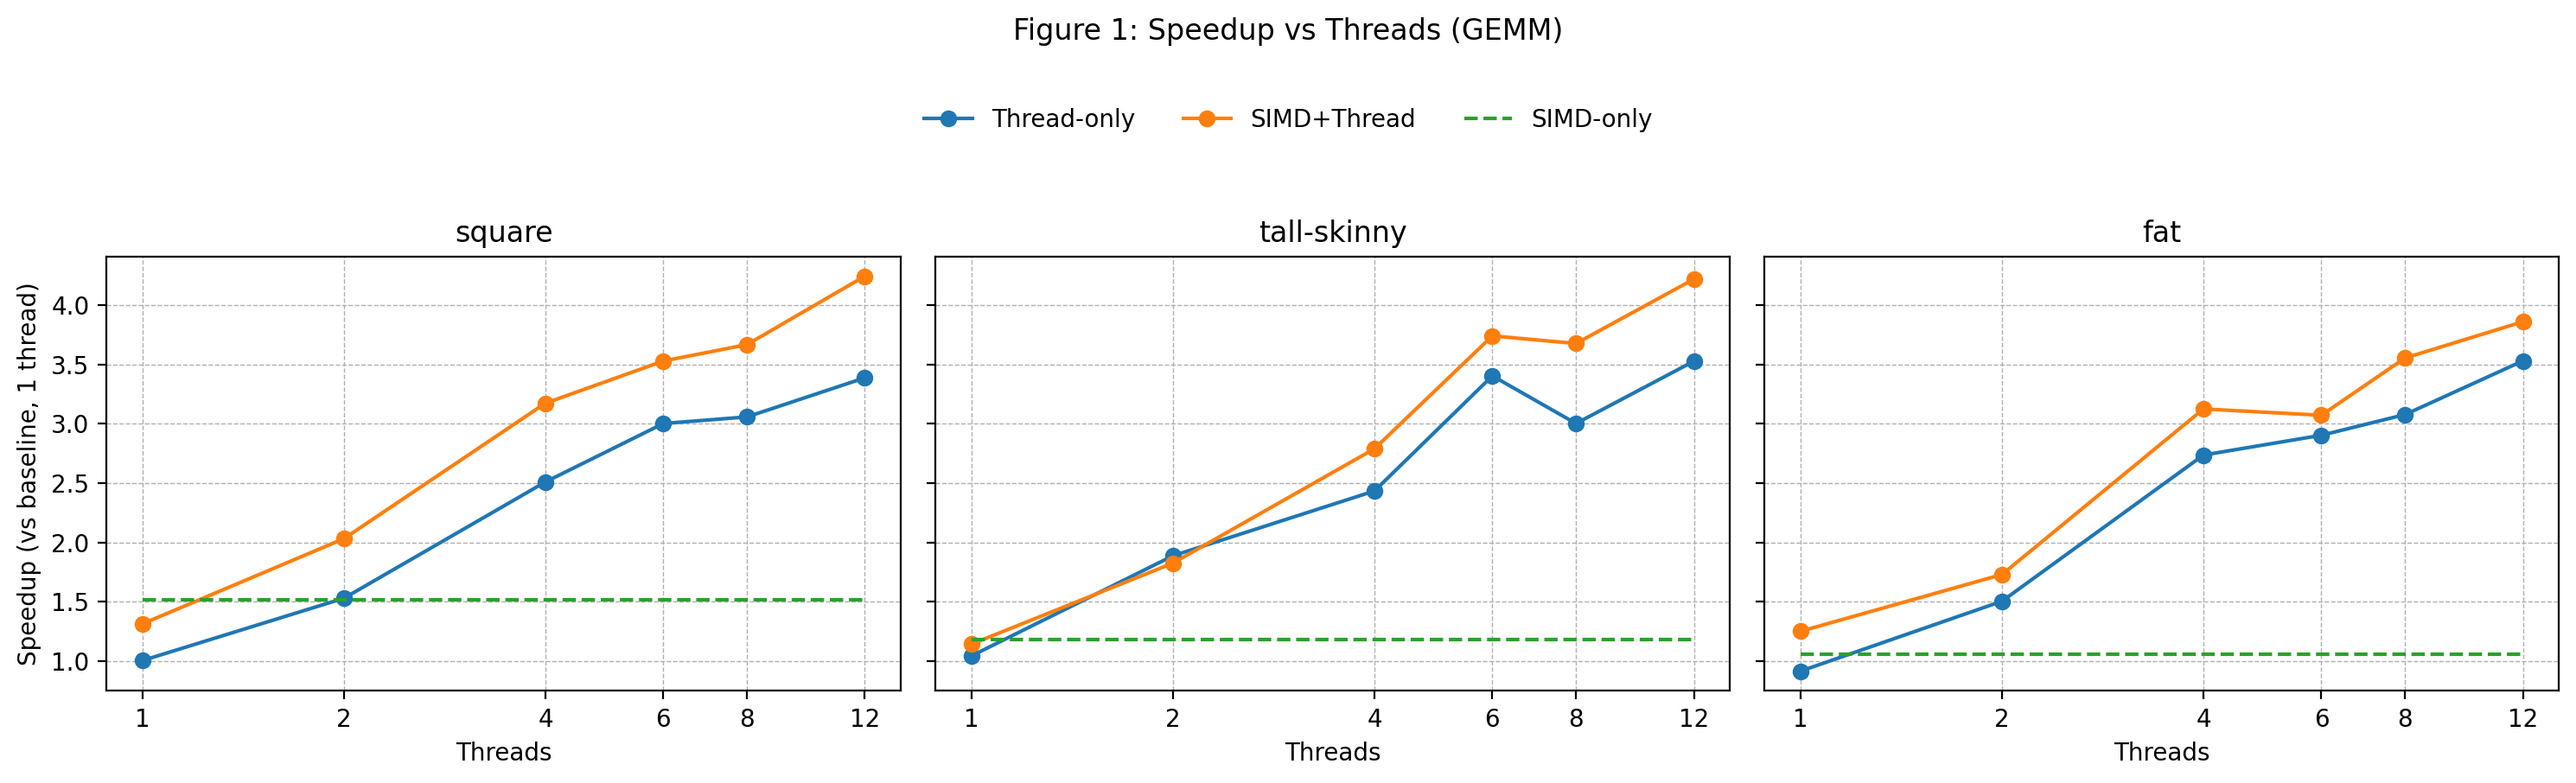 | 
|:----------------------------------------------------:|

In Figure 1：

**SIMD-only:**

SIMD-only provides a constant speedup at a single thread and remains unchanged as the number of threads increases. This is expected because SIMD exploits data-level parallelism within one core and is independent of thread-level parallelism. The speedup is highest for square matrices and decreases for tall-skinny and fat shapes due to less favorable memory access patterns.

**Thread-only:**
Thread-only performance improves as the number of threads increases, showing near-linear scaling up to the number of physical cores(6). Beyond that point, the speedup saturates and in some cases slightly degrades. This behavior is caused by memory bandwidth limitations, cache contention, and SMT overhead when multiple threads share the same core.

**SIMD + Multi-threading**
Combining SIMD with multi-threading consistently achieves higher speedup than thread-only execution across all matrix shapes.

**Conclusion**
Square matrices benefit the most from both SIMD and multi-threading due to higher arithmetic intensity and better cache reuse. Tall-skinny and fat matrices exhibit weaker scaling, especially at higher thread counts, as their memory access patterns reduce data reuse and increase pressure on memory and cache systems.


| 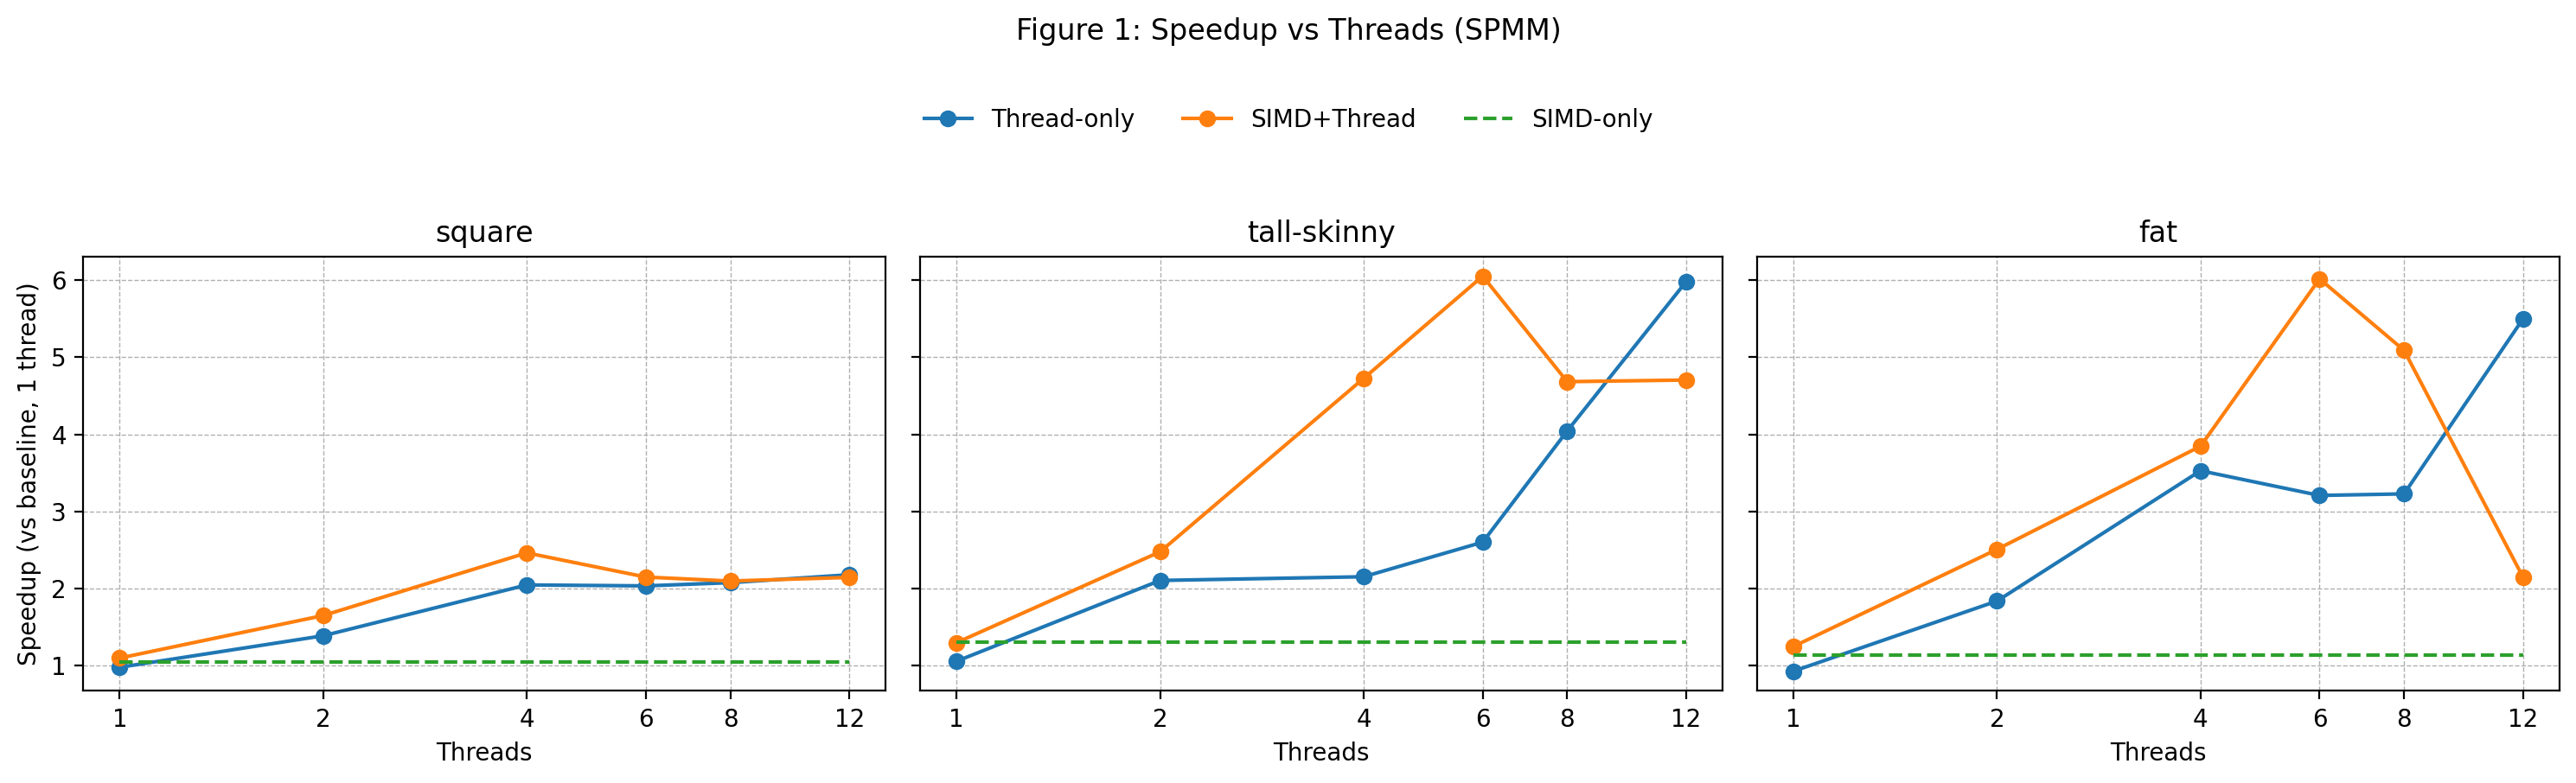 | 
|:----------------------------------------------------:|

In Figure 2：

**Thread-only:**
The scaling behavior is highly shape-dependent. For square matrices, speedup saturates early at around 2–2.5×, indicating strong memory bandwidth limitations. In contrast, tall-skinny and fat matrices scale better, continuing to gain speedup beyond the number of physical cores

**SIMD + Multi-threading**
SIMD combined with multi-threading generally achieves the highest speedup at moderate thread counts, especially for tall-skinny and fat matrices. However, after reaching a peak (6 threads), performance degrades at higher thread counts.

**Conclusion**
CSR-SpMM is strongly memory-bound, and its performance is governed more by memory access patterns than by compute capability. Square matrices benefit the least from parallelization due to early bandwidth saturation. Tall-skinny and fat matrices achieve higher peak speedups, but their performance becomes unstable at high thread counts.

### Dense GEMM GFLOP/s (Square Matrix)

| Threads | Baseline | SIMD  | Thread-only | SIMD + Thread |
| ------- | -------- | ----- | ----------- | ------------- |
| 1       | 24.93    | 37.48 | 24.94       | 32.80         |
| 2       | –        | –     | 38.18       | 56.37         |
| 4       | –        | –     | 54.40       | 69.17         |
| 6       | –        | –     | 67.61       | 90.16         |
| 8       | –        | –     | 68.09       | 87.08         |
| 12      | –        | –     | **75.37**       | **100.10**    |

### Dense GEMM GFLOP/s (Tall-Skinny)

| Threads | Baseline | SIMD  | Thread-only | SIMD + Thread |
| ------- | -------- | ----- | ----------- | ------------- |
| 1       | 23.38    | 35.20 | 24.87       | 31.58         |
| 2       | –        | –     | 38.21       | 49.65         |
| 4       | –        | –     | 59.87       | 74.36         |
| 6       | –        | –     | 67.81       | 87.42         |
| 8       | –        | –     | 74.49       | **94.86**         |
| 12      | –        | –     | **80.07**   | 92.14         |

### Dense GEMM GFLOP/s (Fat)
| Threads | Baseline | SIMD  | Thread-only | SIMD + Thread |
| ------- | -------- | ----- | ----------- | ------------- |
| 1       | 25.30    | 36.29 | 25.18       | 35.85         |
| 2       | –        | –     | 39.95       | 44.34         |
| 4       | –        | –     | 61.39       | 88.39     |
| 6       | –        | –     | 74.90       | 81.49         |
| 8       | –        | –     | 81.41       | 88.14         |
| 12      | –        | –     | **81.76**   | **89.66**         |

### CSR-SpMM GFLOP/s (Square)
| Threads | Baseline |  SIMD | Thread-only | SIMD + Thread |
| ------: | -------: | ----: | ----------: | ------------: |
|       1 |    10.04 | 10.86 |       10.23 |         11.21 |
|       2 |        – |     – |       10.83 |         17.23 |
|       4 |        – |     – |       23.99 |         24.72 |
|       6 |        – |     – |       19.59 |         **24.81** |
|       8 |        – |     – |       18.77 |         23.99 |
|      12 |        – |     – |       **24.58** |         20.36 |

### CSR-SpMM GFLOP/s (Tall-Skinny)
| Threads | Baseline |  SIMD | Thread-only | SIMD + Thread |
| ------: | -------: | ----: | ----------: | ------------: |
|       1 |    11.85 | 16.94 |       12.96 |         18.43 |
|       2 |        – |     – |       24.72 |         34.88 |
|       4 |        – |     – |       33.23 |         40.96 |
|       6 |        – |     – |       48.82 |         44.22 |
|       8 |        – |     – |       48.48 |         **61.99** |
|      12 |        – |     – |       **66.89** |         55.05 |

### CSR-SpMM GFLOP/s (Fat)
| Threads | Baseline |  SIMD | Thread-only | SIMD + Thread |
| ------: | -------: | ----: | ----------: | ------------: |
|       1 |    14.17 | 24.32 |       18.11 |         27.96 |
|       2 |        – |     – |       46.97 |         57.75 |
|       4 |        – |     – |       80.37 |        **111.84** |
|       6 |        – |     – |       69.30 |         85.58 |
|       8 |        – |     – |       91.90 |         93.94 |
|      12 |        – |     – |      **120.10** |       9.63 |


### CSR-SpMM CPNZ (Square)
| Threads | Baseline | SIMD   | Thread-only | SIMD + Thread |
| ------- | -------- | ------ | ----------- | ------------- |
| 1       | 956.77   | 884.50 | 939.49      | 856.77        |
| 2       | –        | –      | 887.22      | 557.70        |
| 4       | –        | –      | 400.43      | 388.61    |
| 6       | –        | –      | 490.43      | **387.25**    |
| 8       | –        | –      | 511.79      | 400.43        |
| 12      | –        | –      | **390.89**      | 471.79        |

### CSR-SpMM CPNZ (Tall-Skinny)
| Threads | Baseline | SIMD   | Thread-only | SIMD + Thread |
| ------- | -------- | ------ | ----------- | ------------- |
| 1       | 810.86   | 567.24 | 741.32      | 521.33        |
| 2       | –        | –      | 388.61      | 275.44        |
| 4       | –        | –      | 289.07      | 234.53    |
| 6       | –        | –      | 196.81      | 217.26        |
| 8       | –        | –      | 198.17      | **154.99**    |
| 12      | –        | –      | **143.63**  | 174.54        |

### CSR-SpMM CPNZ (Fat)
| Threads | Baseline | SIMD   | Thread-only | SIMD + Thread |
| ------- | -------- | ------ | ----------- | ------------- |
| 1       | 678.14   | 394.98 | 530.43      | 343.62        |
| 2       | –        | –      | 204.53      | 166.35        |
| 4       | –        | –      | 119.54      | **85.90**     |
| 6       | –        | –      | 138.63      | 112.27        |
| 8       | –        | –      | 104.54      | 102.27    |
| 12      | –        | –      | **79.99**   | 997.67      |





## 3.3 Density break-even

Fix the shape of matrix: m = 4096, k = 4096, n = 4096

Thread: 6 cores

SIMD: on

Repeats: 3

Densities: = (0.001 0.002 0.005 0.01 0.02 0.05 0.10 0.20 0.30 0.50 0.80 ,1.00)


|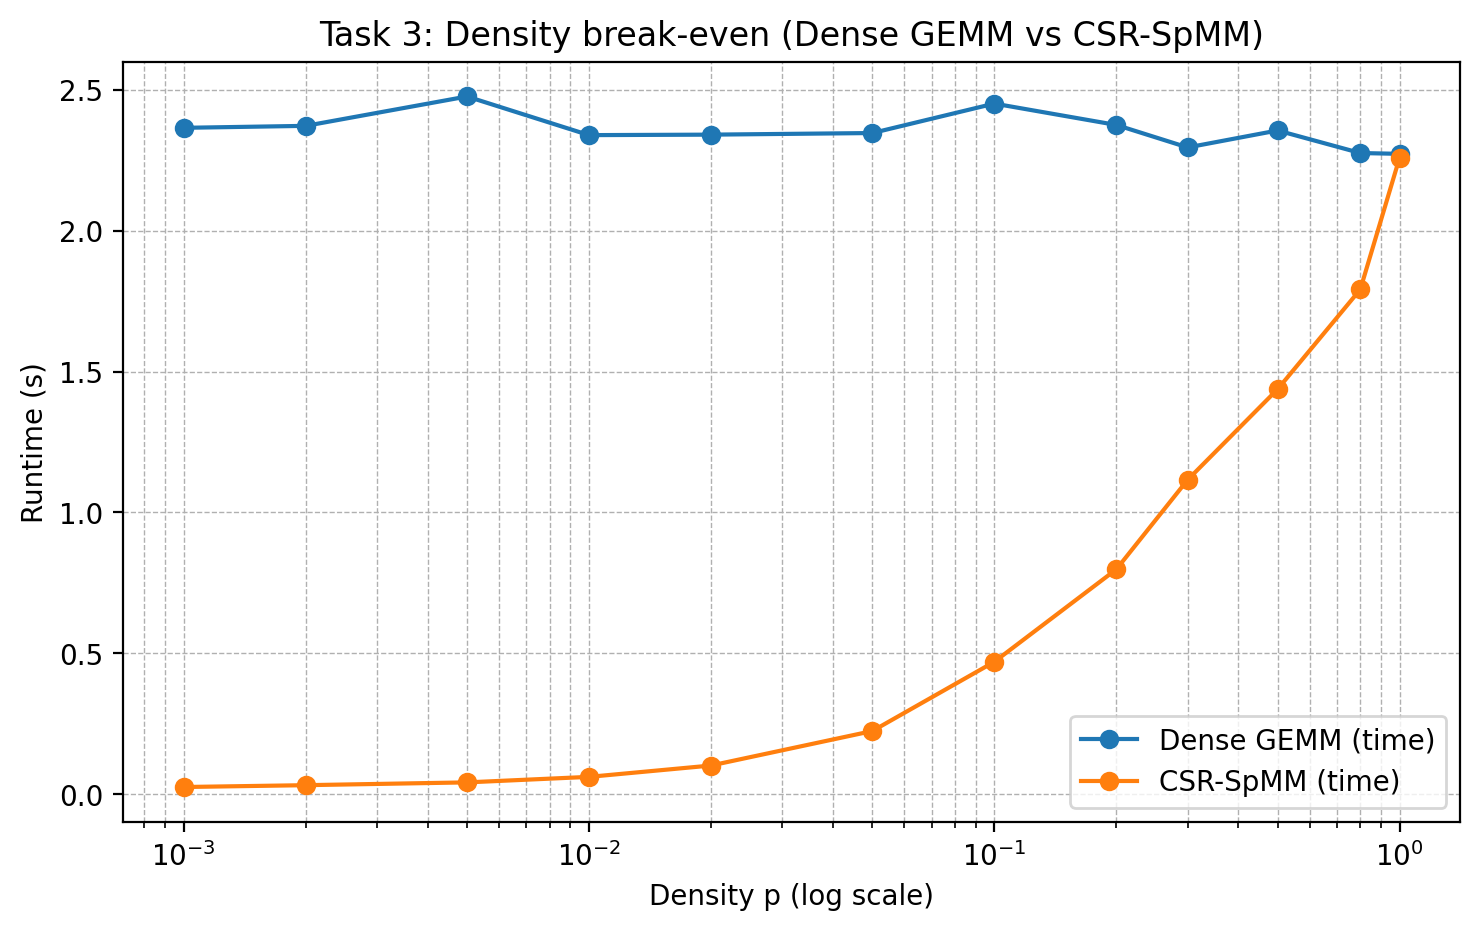|  
|:----------------------------------------------------:|

In this figure, we do not observe the break-even point(close to density = 1). This indicates that CSR-SpMM is faster than Dense GEMM for nearly the entire density range, and only becomes comparable when the sparse matrix is almost fully dense.

CSR-SpMM is strongly memory-bound due to irregular memory access patterns. Memory bandwidth and cache misses dominate performance, especially at higher densities. Dense GEMM makes far more efficient use of cache and memory bandwidth, which explains why its runtime remains flat while CSR-SpMM degrades.

## 3.4 Working-set transitions:

SIMD: on

Thread: 6 cores

Repeats: 3

Density: 1%

**Cache hierarchy:**

L1d: 32 KB per core × 6

L1i: 32 KB per core × 6

L2: 1 MB per core × 6

L3: 32 MB shared

**Size:**

Matrix N = [64 128 192 256 320 384 512 768 1024 1536 1792 2048 3072 4096]



| 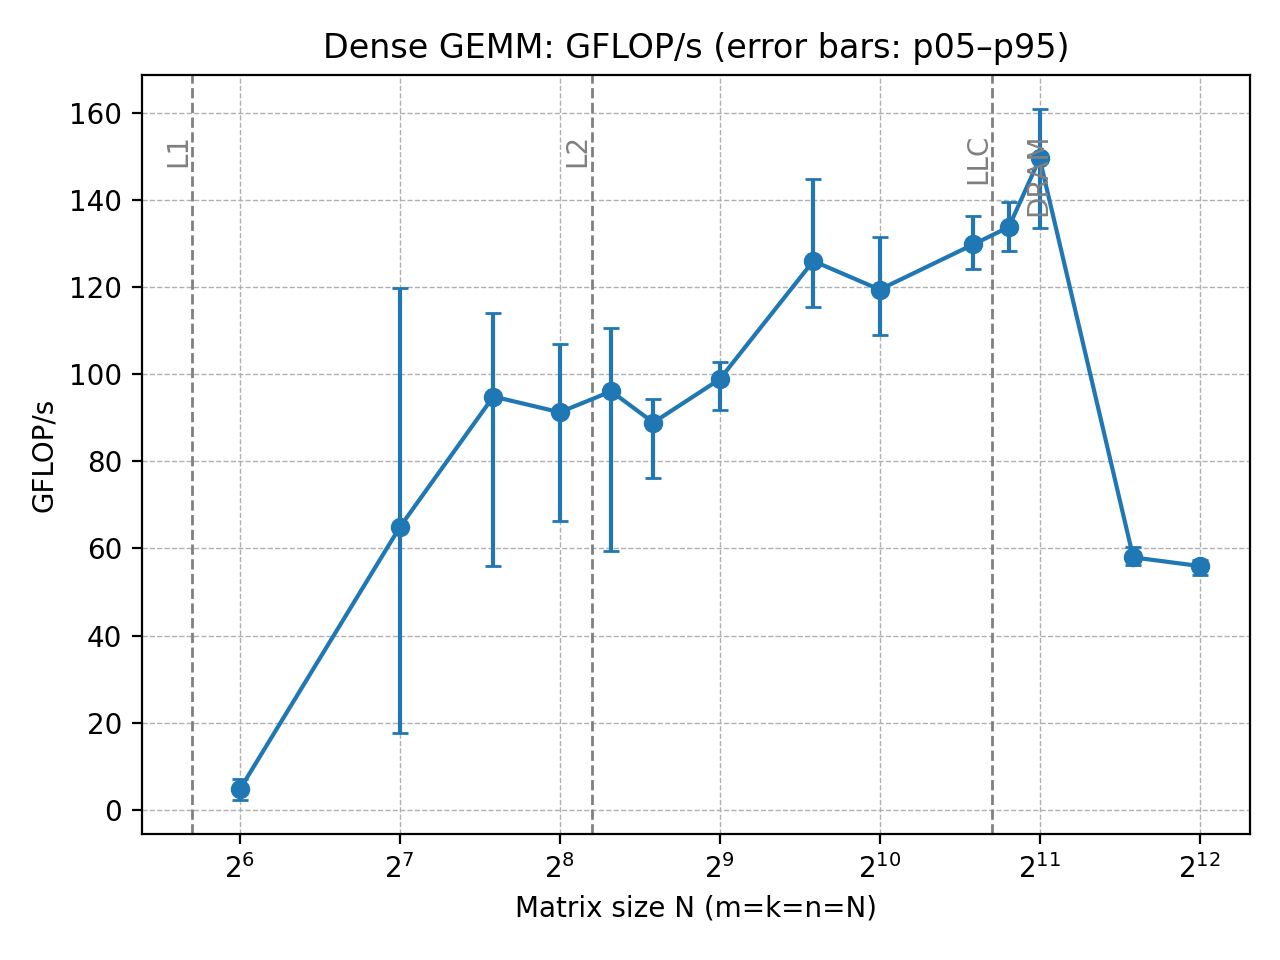 | 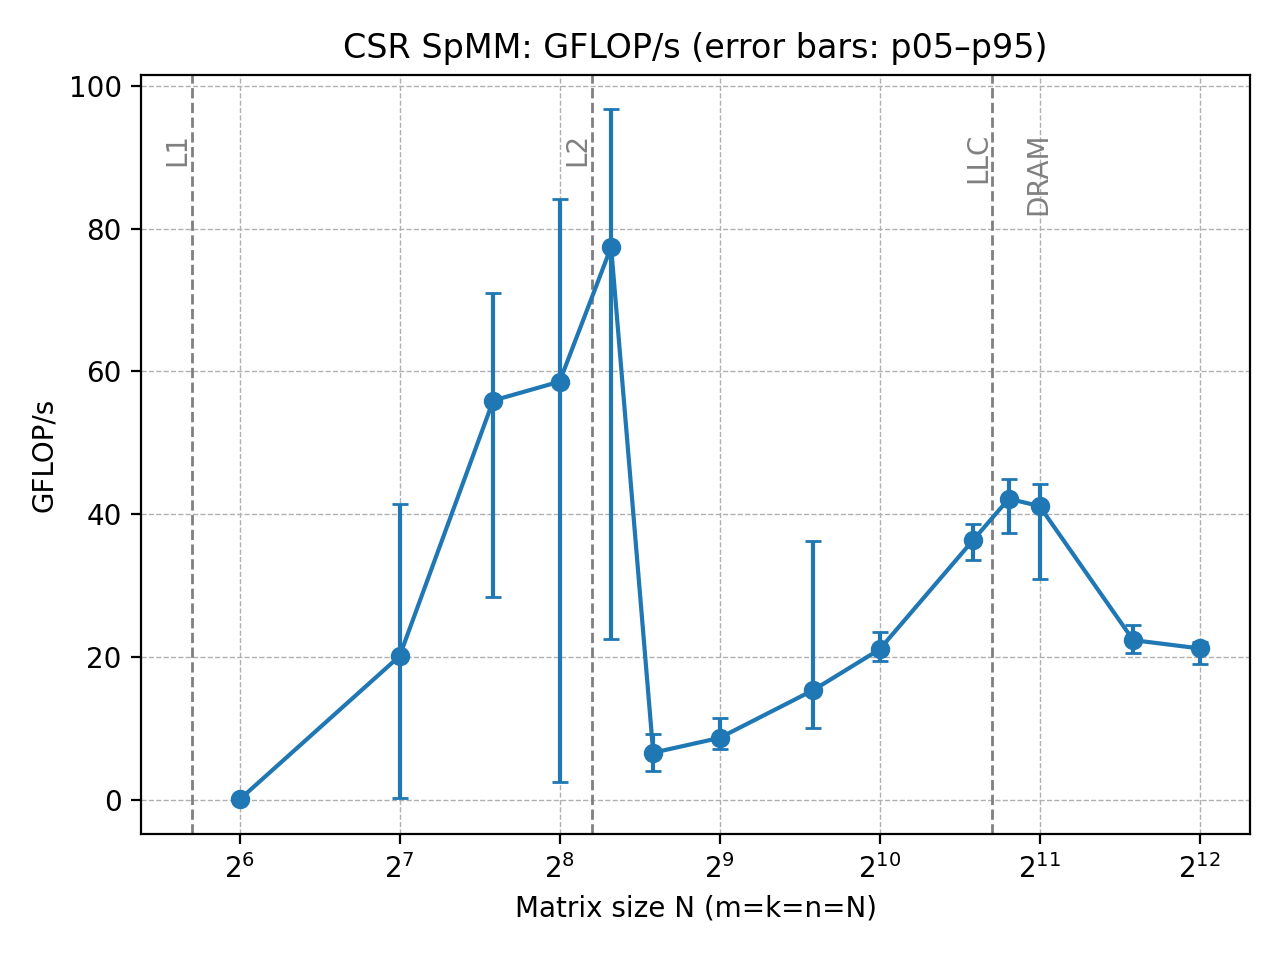|
|:----------------------------------------------------:|:----------------------------------:|

Based on an approximate working-set estimate: 12 * N * N bytes, the cache capacity boundaries are:

L1: N = 52

L2: N = 294

L3(LLC): LLC = 1665

DRAM: N > L3

**For the left figures:**

N = 64 - 256: GFLOP/s increases rapidly, indicating a transition from cache execution to higher compute utilization.

N = 256 - 512: Performance enters a high status, cache hierarchy can still supply data efficiently.

N = 1024 - 2048: FLOP/s remains high and even reaches a peak (around N=2048)

N = 3072 - 4096: FLOP/s drops sharply to ~55–60. May encounter memory bandwidth, cache misses.

**For the right figures:**

N = 64 - 256: GFLOP/s increases and reaches a relatively high level. 

N = 384 - 512: GFLOP/s suddenly drops to only a few GFLOP/s. I think it is because poor spatial locality and load imbalance.

N = 768 - 2048: Performance gradually recovers.

N = 3072 - 4096: GFLOP/s decreases again to ~20, indicating that SpMM becomes strongly dominated by DRAM accesses and is more easily memory-bound in this regime.




| 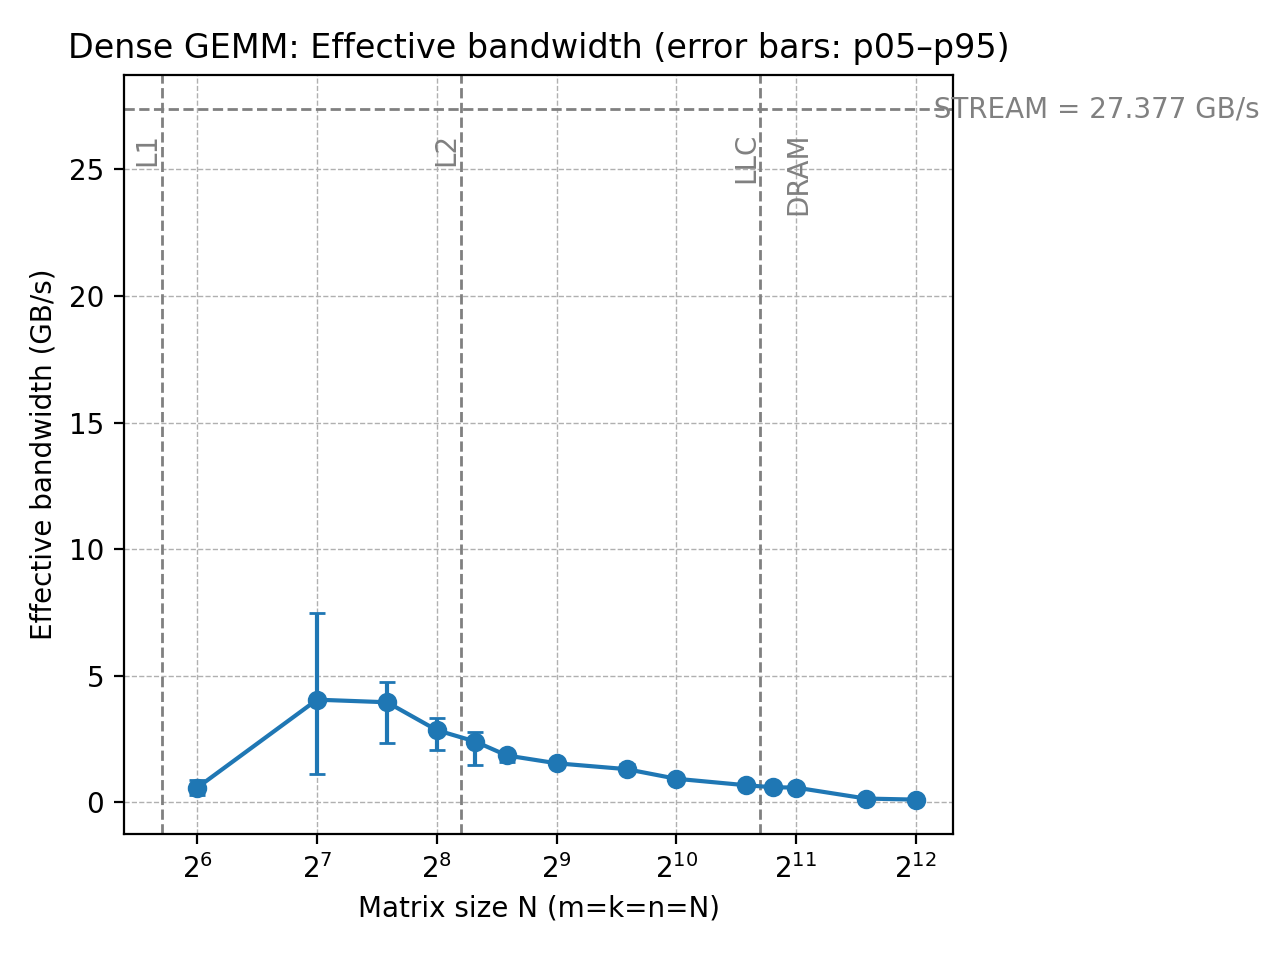 | 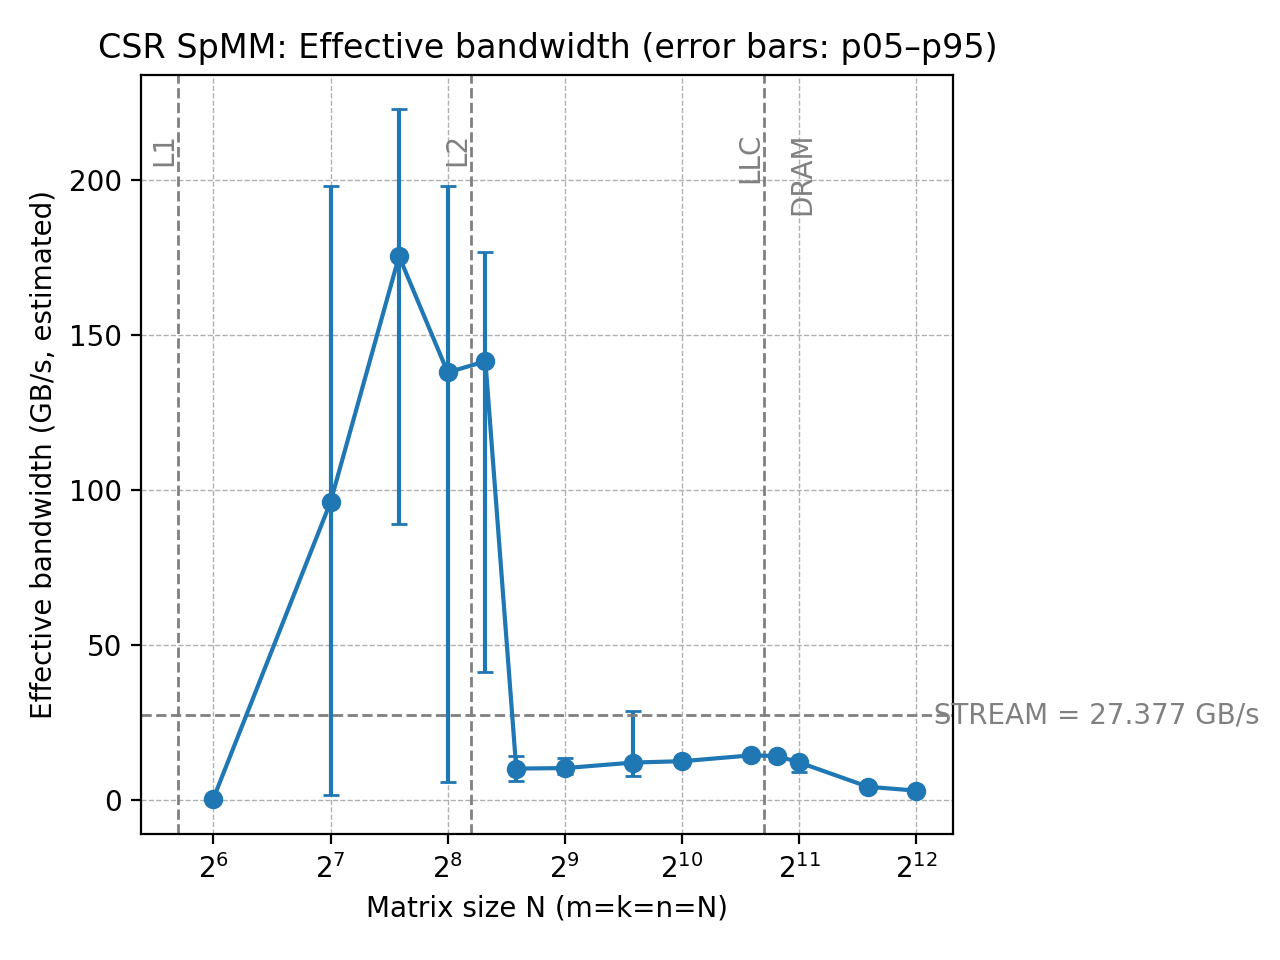|
|:----------------------------------------------------:|:----------------------------------:|

For Dense GEMM, effective bandwidth remains low across most sizes and steadily decreases as the working set grows, staying well below the measured STREAM bandwidth. This indicates that GEMM benefits from strong data reuse and is not bandwidth-bound until the working set clearly exceeds the LLC.

In contrast, CSR SpMM exhibits much higher and more variable effective bandwidth at small sizes, reflecting heavy cache traffic and irregular access patterns. As the working set crosses L2 and LLC, effective bandwidth drops and stabilizes at a lower level, and once operating beyond the LLC, SpMM becomes strongly dominated by DRAM accesses.

Overall, Dense GEMM remains largely compute-bound, while CSR SpMM is more memory-bound, especially in the DRAM regime.

## 3.5 Roofline

I use FP32 + AVX2 + FMA

Flops/cycle/core = 32

Peak FLOPS: 6 x 4.69 x 32 = 900 GFLOP/s

Estimated bandwidth: 27.377GB/s

Ridge point: AI = Peak FLOPS / bandwidth = 33 FLOP/Byte

So Kernels with arithmetic intensity below 33 FLOP/Byte are bandwidth-bound, while those above it are compute-bound.

I use the points in exp 3.4 to draw the model:

|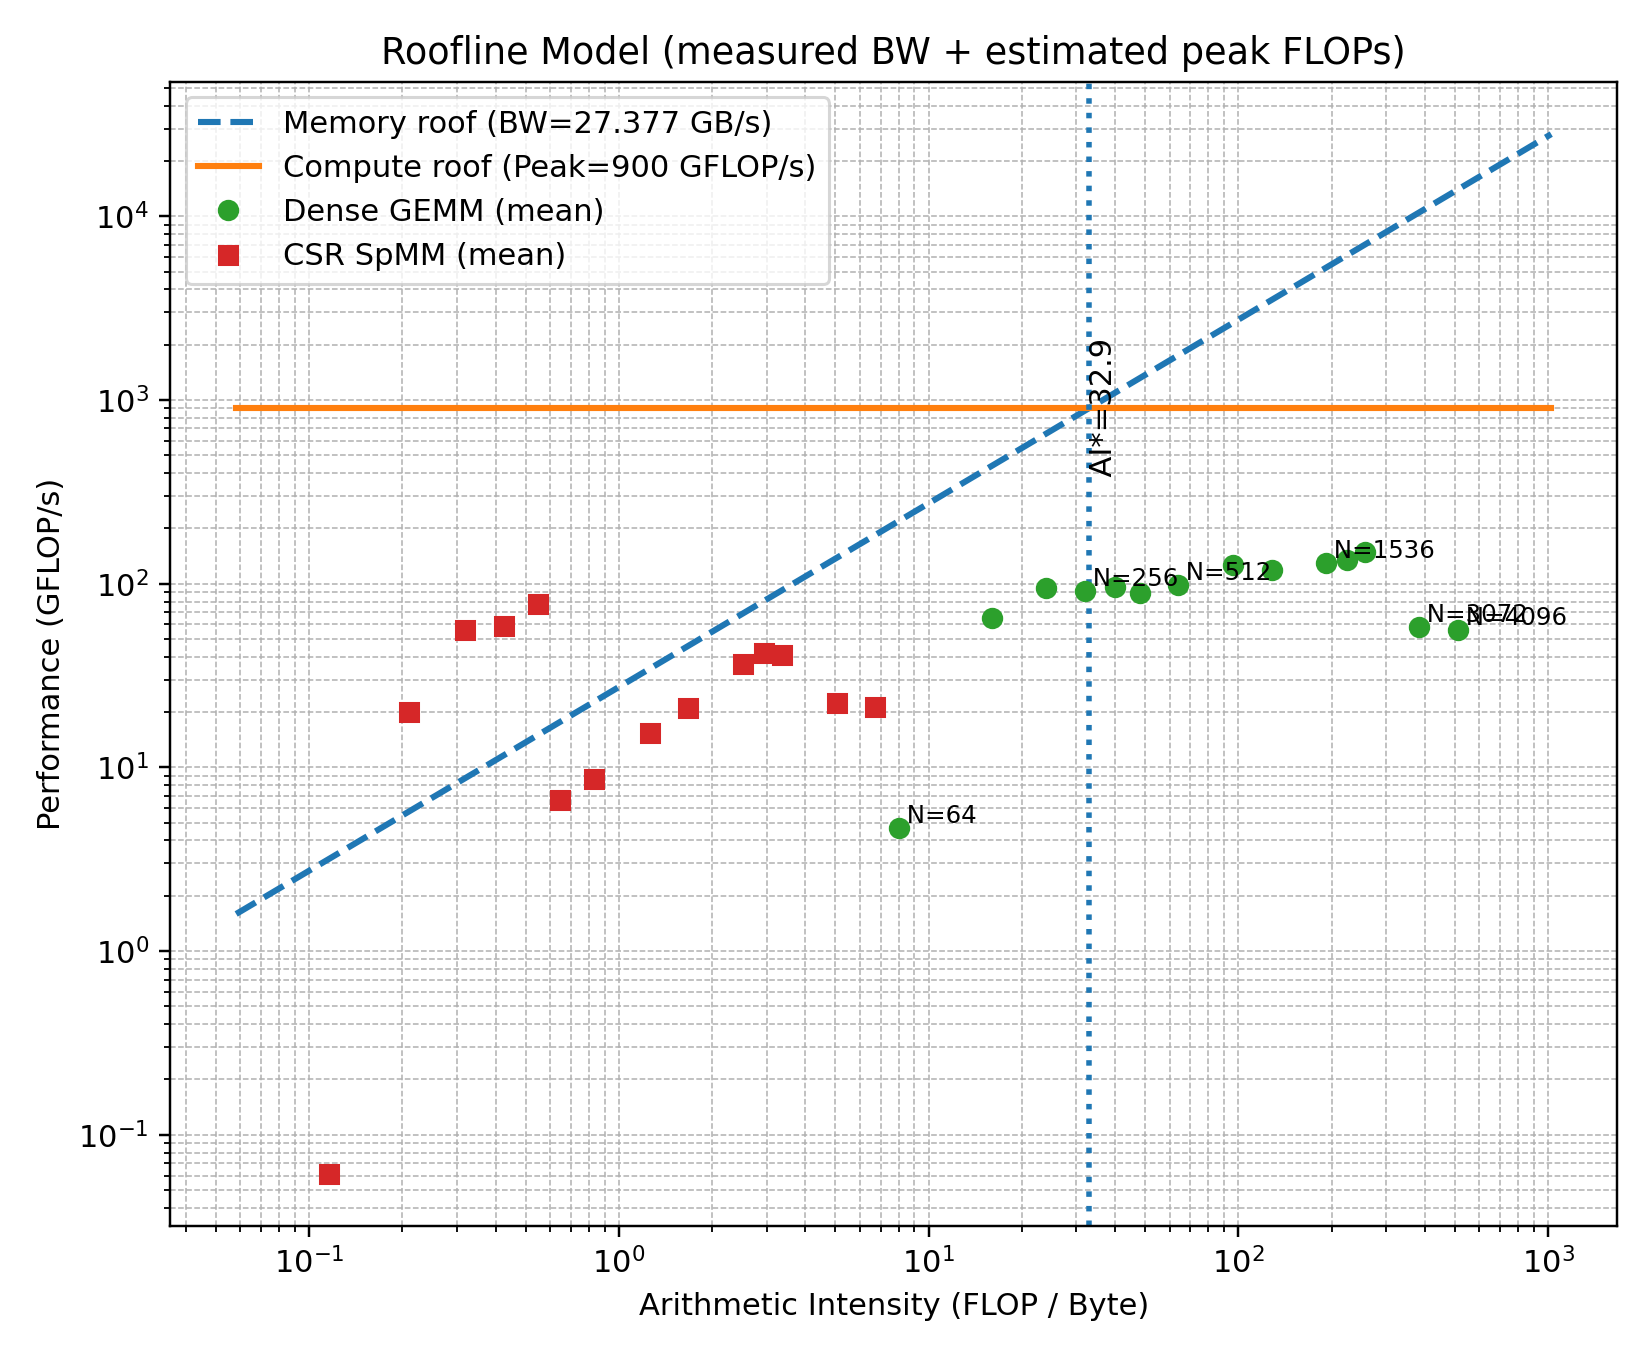|  
|:----------------------------------------------------:|

From this figure, For large N, GEMM reaches AI = 50–200 FLOP/Byte. they all in the compute-bound regime. CSR SpMM exhibits low arithmetic intensity, which in the range of approximately 0.1–10 FLOP/Byte, this means SpMM performance remains limited by memory bandwidth.

On my system, the high ridge point of the roofline model strongly favors dense, compute-intensive workloads, while sparse matrix operations remain memory-bound across all problem sizes due to low arithmetic intensity and irregular memory access patterns.